# Clustering of all data

Read in all necessary packages:

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.io.parsers import read_csv
#import scvelo as scv
import scanpy as sc
import numpy as np
from functools import reduce
from anndata import AnnData, read_h5ad
#import singlecellmultiomics.bamProcessing.bamToRNACounts
import loompy
from sklearn.mixture import GaussianMixture
from numpy import hstack
from numpy.random import normal
from sklearn.neighbors import NearestNeighbors
#from pyod.models.mad import MAD

In [4]:
def calculateCovEnr(df,adatafile,neighbors,mincounts):
    df=df.loc[:,df.sum(axis=0)>=mincounts].T
    cellnames=adatafile.obs.index
    cellnames=cellnames[cellnames.isin(df.index)]
    df=df[df.index.isin(cellnames)]
    adatafile=adatafile[cellnames]
    PCAs=adatafile.obsm['X_pca']
    nbrs = NearestNeighbors(n_neighbors=neighbors, algorithm='auto').fit(PCAs)
    distances, indices = nbrs.kneighbors(PCAs)
    neighborslist=pd.DataFrame(indices)
    neighborslist.index=cellnames
    
    returndf=pd.DataFrame(columns={'QC','coverage','enrichment','reads'}, index=cellnames)

    for name in cellnames:
        #select neighbours
        subset=df.loc[cellnames[neighborslist.loc[name]]].T
        subset['sum']=(subset/subset.sum(axis=0)).sum(axis=1)
        subset = subset.sort_values('sum', ascending=False)
        subsetsums = subset['sum']
        covercounter1  =0
        covercounter2 = 0
        counteraim = sum(subsetsums)*.8
        for counter2 in subsetsums:
            if covercounter1 < counteraim:
                covercounter1 = covercounter1+counter2
                covercounter2 = covercounter2+1

        coverage = covercounter2/50000
        testlist = subset[name]

        returndf.loc[name,'coverage'] = (coverage * 100)
        returndf.loc[name,'enrichment'] = ((testlist.head(round(len(testlist)*coverage))).sum()/(testlist).sum())*100
        returndf.loc[name,'reads'] = df.loc[name].sum()
    return returndf

In [7]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

#scv.set_figure_params('scvelo')  # for beautified visualization
sc.set_figure_params(dpi=150, color_map = 'viridis')

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.5 python-igraph==0.9.10 pynndescent==0.5.10


In [54]:
greens_r = sns.blend_palette(['black','#238b45', '#75c477', '#c8e9c1' ], as_cmap = True)
purples_r = sns.blend_palette(['black','#6a51a3', '#9e9bc8', '#dadaeb'], as_cmap = True)
oranges_r = sns.blend_palette(['black','#d94801', '#fd8e3d', '#fdd1a3'], as_cmap = True)

greens = sns.blend_palette(['white','#c8e9c1', '#75c477','#238b45'  ], as_cmap = True)
purples = sns.blend_palette(['white','#dadaeb', '#9e9bc8','#6a51a3' ], as_cmap = True)
oranges = sns.blend_palette(['white','#fdd1a3', '#fd8e3d','#d94801' ], as_cmap = True)

k27_k4 = sns.blend_palette(['#6a51a3', '#9e9bc8', '#dadaeb','#c8e9c1','#75c477','#238b45'], as_cmap = True)
k4_k27 = sns.blend_palette(['#238b45', '#75c477', '#c8e9c1' ,'#dadaeb','#9e9bc8','#6a51a3' ], as_cmap = True)
Green='#238b45'
Purple='#6a51a3'
Orange='#d94801'

In [72]:
sc.set_figure_params(dpi = 80)
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")

# Load the dataset

In [8]:


adata = sc.read('20230324_allGastruloids2.h5ad')

adata

AnnData object with n_obs × n_vars = 47598 × 25778
    obs: 'batch2', 'batch', 'day', 'replicates', 'mark', 'day_rep', 'dataset', 'cellnames', 'bc', 'cellname', 'percent_mito', 'n_counts', 'n_counts_proteincoding', 'n_counts_stressgenes', 'n_genes', 'S_score', 'G2M_score', 'phase', 'histone_score', 'mark_binary', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'umap_density_mark'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_biotype', 'gene_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'dataset_colors', 'day_colors', 'diffmap_evals', 'dpt_changepoints', 'dpt_groups_colors', 'dpt_grouptips', 'draw_graph', 'hvg', 'iroot', 'log1p', 'mark_colors', 'neighbors', 'pca', 'phase_colors', 'replicates_colors', 'umap', 'umap_density_mark_params'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    ob

Create scatterplot explaining neighbor usage

In [ ]:
#load adata with final UMAP coordinates to not confuse

adata3 = sc.read_h5ad('20230619_allGastruloids_UMAP_celltypes_incChroms_norm.h5ad')


#identify 200 nearest neighbors for each cell 
PCAs=adata3.obsm['X_pca']
nbrs = NearestNeighbors(n_neighbors=200, algorithm='auto').fit(PCAs)
distances, indices = nbrs.kneighbors(PCAs)
neighborslist=pd.DataFrame(indices)
neighborslist.index=adata3.obs.index



In [ ]:
#set cell to look at and plot in umap space

cellnumber=2846

plottableUMAP=pd.DataFrame(adata3.obsm['X_umap'])
plottableUMAP.index=adata3.obs.index
plottableUMAP.columns=['umap1','umap2']

plottableUMAP['stat']='all'
plottableUMAP2=plottableUMAP.loc[neighborslist.iloc[neighborslist.loc[plottableUMAP.index[cellnumber]]].index]
plottableUMAP2['stat']='neigh'
plottableUMAP2.loc[plottableUMAP.index[cellnumber],'stat']='cent'

sns.scatterplot(data=plottableUMAP, x='umap1', y='umap2', s=5, linewidth=0, color='Lightgrey',legend=False)
sns.scatterplot(data=plottableUMAP2.iloc[::-1], x='umap1', y='umap2', hue='stat', s=50, linewidth=0, palette=['Black','Red'], hue_order=['neigh','cent'],legend=False)

plt.savefig('figures/fig3/nearest_cells.png', dpi=300, format='png', bbox_inches='tight')

prepare data to identify encrichment and counts per cell for filtering

In [9]:
adata=adata[~((adata.obs['day']=='Gastd3')&(adata.obs['replicates']=='rep4'))]
adata

View of AnnData object with n_obs × n_vars = 43282 × 25778
    obs: 'batch2', 'batch', 'day', 'replicates', 'mark', 'day_rep', 'dataset', 'cellnames', 'bc', 'cellname', 'percent_mito', 'n_counts', 'n_counts_proteincoding', 'n_counts_stressgenes', 'n_genes', 'S_score', 'G2M_score', 'phase', 'histone_score', 'mark_binary', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'umap_density_mark'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_biotype', 'gene_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'dataset_colors', 'day_colors', 'diffmap_evals', 'dpt_changepoints', 'dpt_groups_colors', 'dpt_grouptips', 'draw_graph', 'hvg', 'iroot', 'log1p', 'mark_colors', 'neighbors', 'pca', 'phase_colors', 'replicates_colors', 'umap', 'umap_density_mark_params'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced

In [10]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:12)


In [11]:
adataK4 = adata[adata.obs['mark']=='H3K4me3']
adataK27 = adata[adata.obs['mark']=='H3K27me3']

In [ ]:
#load whole genome bin data
H3K4me3_total=pd.read_csv('H3K4me3_merged_count_table_50000.csv', header=0, index_col=(0,1,2),low_memory=True)
H3K27me3_total=pd.read_csv('H3K27me3_merged_count_table_50000.csv', header=0, index_col=(0,1,2),low_memory=True)


In [ ]:
#do test, do both marks independently and restart kernel inbetween
#K4 read cutoff 300 K27 read cutoff 900

In [15]:
testresultsK4=calculateCovEnr(H3K4me3_total,adataK4,200,0)

In [16]:
testresultsK27=calculateCovEnr(H3K27me3_total,adataK27,200,0)

In [ ]:
#evaluate results

In [26]:
testresultsK4['QC']='good'
testresultsK4.loc[testresultsK4['enrichment']<65,'QC']='bad'
testresultsK4.loc[testresultsK4['reads']<300,'QC']='bad'
testresultsK4['mod']='H3K4me3'

testresultsK27['QC']='good'
testresultsK27.loc[testresultsK27['enrichment']<65,'QC']='bad'
testresultsK27.loc[testresultsK27['reads']<900,'QC']='bad'
testresultsK27['mod']='H3K27me3'


In [89]:
# add day information and log10 read counts
QC=pd.concat([testresultsK4,testresultsK27])
days=adata.obs['day']
QC['days']=days

QC['days2']=0
QC.loc[QC['days']=='Gastd3','days2']=1
QC.loc[QC['days']=='Gastd4','days2']=2
QC.loc[QC['days']=='Gastd5','days2']=3
QC.loc[QC['days']=='Gastd6','days2']=4
QC.loc[QC['days']=='Gastd7','days2']=5
QC['reads_log10']=np.log10(pd.to_numeric(QC['reads'])+1)

In [83]:
#safe results
testresultsK4.to_csv('testresults_H3K4me3_final_all.csv')
testresultsK27.to_csv('testresults_H3K27me3_final_all.csv')
QC.to_csv('testresults_merged_allcells.csv')

plot selection statistics

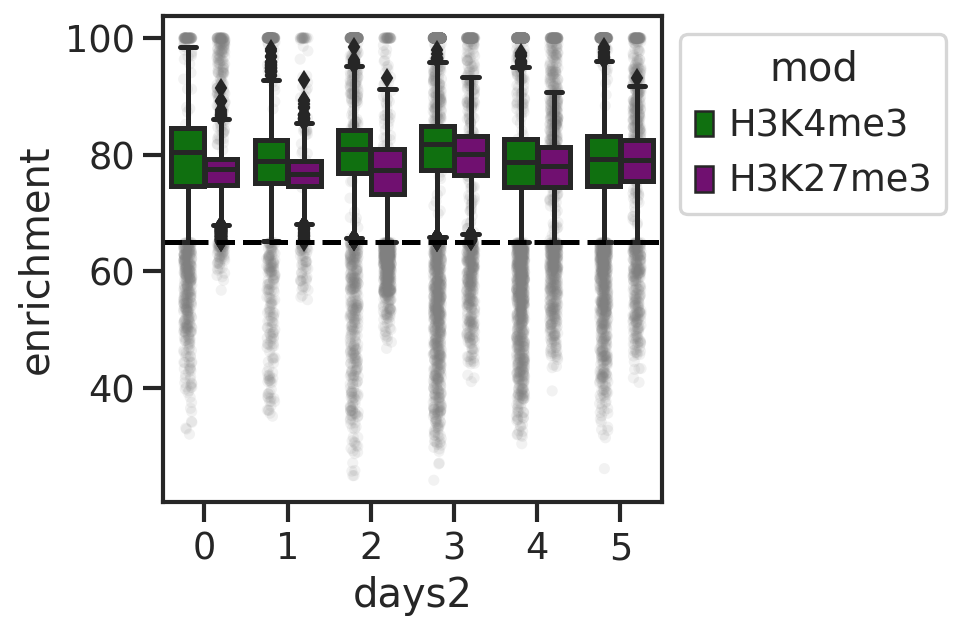

In [87]:
ax=sns.stripplot(data=QC[QC['QC']=='bad'], x="days2", y="enrichment", hue="mod", dodge=True, palette=['Grey','Grey'], alpha=0.1, legend=False, zorder=0)
ax=sns.boxplot(data=QC[QC['QC']=='good'], x="days2", y="enrichment", hue="mod", dodge=True, palette=['Green','Purple'], zorder=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.axhline(65, ls='--', color='Black')
plt.savefig('figures/fig3/cell_selection_enrichment_v2.png', dpi=300, format='png', bbox_inches='tight')

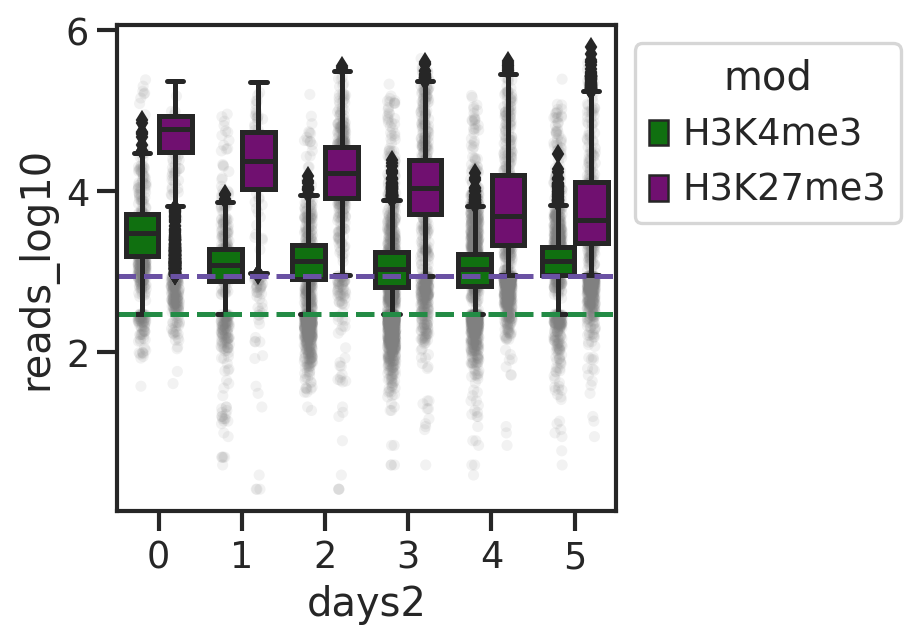

In [88]:
ax=sns.stripplot(data=QC[QC['QC']=='bad'], x="days2", y="reads_log10", hue="mod", dodge=True, palette=['Grey','Grey'], alpha=0.1, legend=False, zorder=0)
ax=sns.boxplot(data=QC[QC['QC']=='good'], x="days2", y="reads_log10", hue="mod", dodge=True, palette=['Green','Purple'], zorder=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.axhline(2.477, ls='--', color=Green)
ax.axhline(2.954, ls='--', color=Purple)
plt.savefig('figures/fig3/cell_selection_reads_v2.png', dpi=300, format='png', bbox_inches='tight')